# Plotting
In this notebook, we are going to plot and visualise our data. 

### Standard Python + R setup and imports

Work in this notebook so I can test viz in R as well.
Also imported fuzzy pandas.

In [14]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import fuzzy_pandas as fpd

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
%%R

# My commonly used R imports
require('tidyverse')

## Clean up

The 2022 window summer was in lowercase, im cleaning it up now before i get into deeper shit.

In [162]:
# This is the not the original df, I have overwritten it
df = pd.read_csv('year_wise.csv')
df.sample(5)
#remove the Unnamed: 0 column
df = df.drop('Unnamed: 0', axis=1)
df.sample(5)

,league_name,year,transfer_period,fee_cleaned
131,Eredivisie,2008,Winter,12.115
391,Premier Liga,2016,Winter,33.270
365,Premier Liga,2003,Winter,34.845
151,Eredivisie,2018,Winter,9.150
301,Premier League,2002,Summer,281.760


In [163]:
#move df to a csv
df.to_csv('year_wise.csv')
df.head(20)
#show me summer 2022
df[df['year'] == 2022]
#replace transfer_period summer with Summer
df['transfer_period'] = df['transfer_period'].replace('summer', 'Summer')

In [164]:

df.to_csv('year_wise.csv')

In [165]:
#unique league_names
df['league_name'].unique()

array(['1 Bundesliga', 'Championship', 'Eredivisie', 'Liga Nos',
       'Ligue 1', 'Premier League', 'Premier Liga', 'Primera Division',
       'Serie A'], dtype=object)

In [166]:
%%R

df <- read_csv('year_wise.csv')





New names:
• `` -> `...1`
Rows: 525 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): league_name, transfer_period
dbl (3): ...1, year, fee_cleaned

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [167]:
#round fee_cleaned to 2 decimal places
df$fee_cleaned <- round(df$fee_cleaned, 2)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


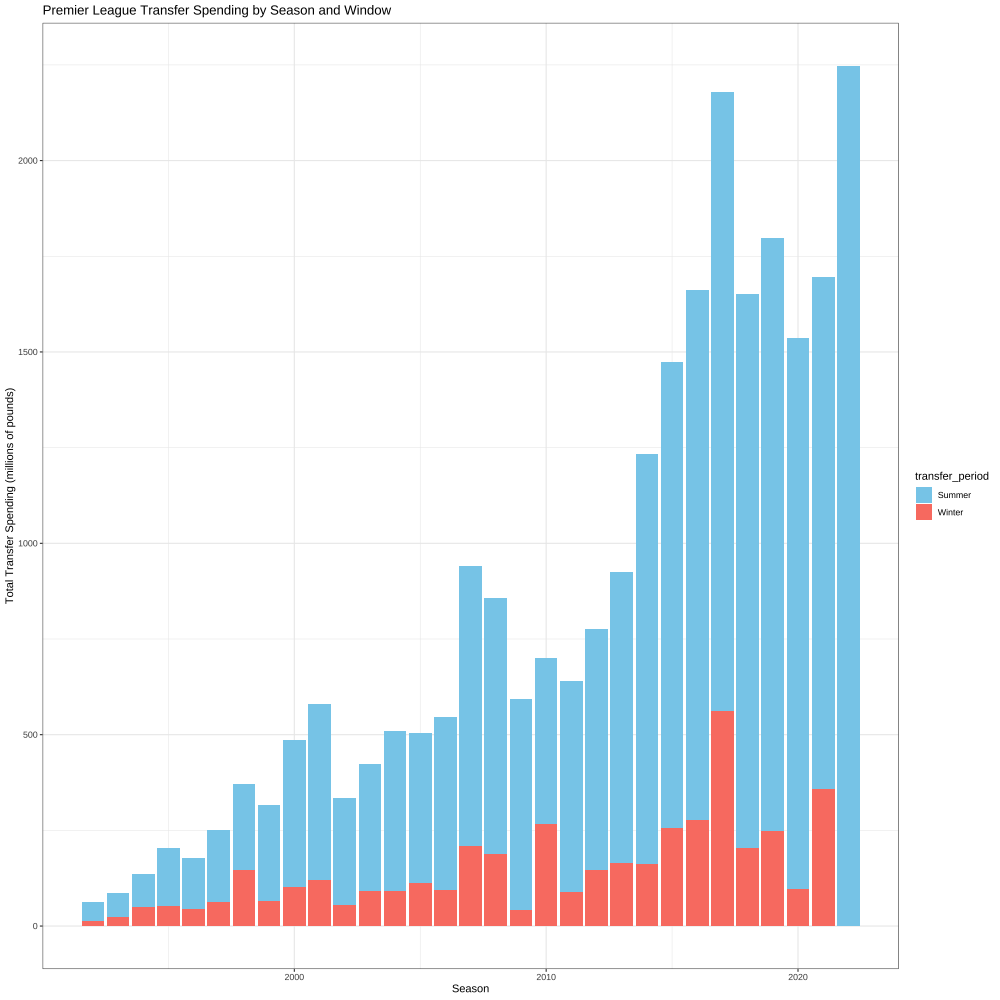

In [171]:
%%R -w 1000 -h 1000

df$fee_cleaned <- round(df$fee_cleaned, 2)

df_analyse <- df %>% 
  filter(league_name == "Premier League")

# aggregate the data by year and transfer window
df_sum <- df_analyse %>% 
  group_by(year, transfer_period) %>% 
  summarise(total_spent = sum(fee_cleaned)) %>% 
  ungroup()

# plot the data
ggplot(df_sum, aes(x = year, y = total_spent, fill = transfer_period)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = c("Summer" = "skyblue", "Winter" = "salmon")) +
  labs(title = "Premier League Transfer Spending by Season and Window",
       x = "Season", y = "Total Transfer Spending (millions of pounds)") +
  theme_bw()



`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


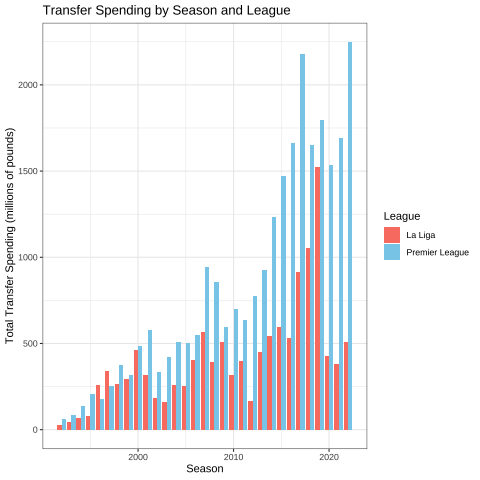

In [169]:
%%R

df_analyse <- df %>% 
  filter(league_name %in% c("Premier League", "Primera Division")) %>%
  mutate(league_name = ifelse(league_name == "Primera Division", "La Liga", league_name))

# aggregate the data by year and league name
df_sum <- df_analyse %>% 
  group_by(year, league_name) %>% 
  summarise(total_spent = sum(fee_cleaned)) %>% 
  ungroup()

# plot the data
ggplot(df_sum, aes(x = year, y = total_spent, fill = league_name)) +
  geom_col(position = "dodge") +
  scale_fill_manual(values = c("Premier League" = "skyblue", "La Liga" = "salmon")) +
  labs(title = "Transfer Spending by Season and League",
       x = "Season", y = "Total Transfer Spending (millions of pounds)", fill = "League") +
  theme_bw()



`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


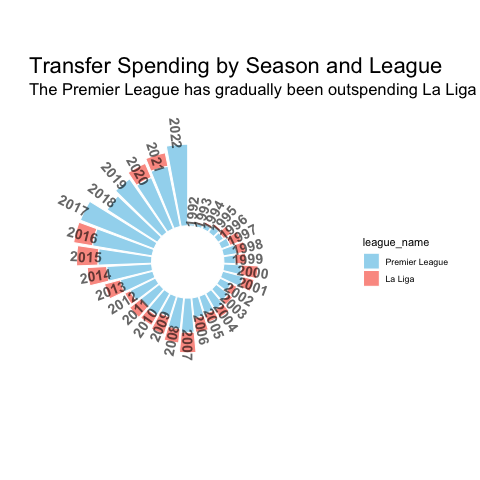

In [77]:
%%R


df_analyse <- df %>% 
  filter(league_name %in% c("Premier League", "Primera Division")) %>%
  mutate(league_name = ifelse(league_name == "Primera Division", "La Liga", league_name))

# aggregate the data by year and league name
df_sum <- df_analyse %>% 
  group_by(year, league_name) %>% 
  summarise(total_spent = sum(fee_cleaned)) %>% 
  ungroup()

# create a new data frame for label positions
label_data <- df_sum %>% 
  group_by(year) %>% 
  summarise(fee_cleaned = max(total_spent)) %>% 
  ungroup()

# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (as.numeric(factor(label_data$year))-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)

# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust<-ifelse(angle < -90, 1, 0)

# flip angle BY to make them readable
label_data$angle<-ifelse(angle < -90, angle+180, angle)

ggplot(df_sum, aes(x=year, y=total_spent, fill=league_name)) +
  # This add the bars with a blue color
  geom_bar(stat="identity", color="white", alpha=0.8) +
  
  # Limits of the plot = very important. The negative value controls the size of the inner circle, the positive one is useful to add size over each bar
  ylim(-1000,2500) +
  
  # Custom the theme: no axis title and no cartesian grid
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm")      # Adjust the margin to make in sort labels are not truncated!
  ) +
  
  # This makes the coordinate polar instead of cartesian.
  coord_polar(start = 0) +
  
  # Add the labels, using the label_data dataframe that we have created before
  geom_text(data=label_data, aes(x=year, y=(fee_cleaned-100)*ifelse(fee_cleaned>0,1,-1), label=year, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=5, angle= label_data$angle, inherit.aes = FALSE ) +
  
  # Adjust the size of the title and subtitle
  labs(title = "Transfer Spending by Season and League",
       subtitle = "The Premier League has gradually been outspending La Liga") +
  theme(plot.title = element_text(size = rel(2)), plot.subtitle = element_text(size = rel(1.5)), plot.margin = unit(c(2, 0.5, 2, 0.5), "cm")) +
  
  # Custom the legend
  guides(fill = guide_legend(reverse = TRUE)) +
  scale_fill_manual(values = c("Premier League" = "skyblue", "La Liga" = "salmon")) 




In [148]:
#filter df to only include years after 1999
df = df[df['year'] > 1999]
#round all the 

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


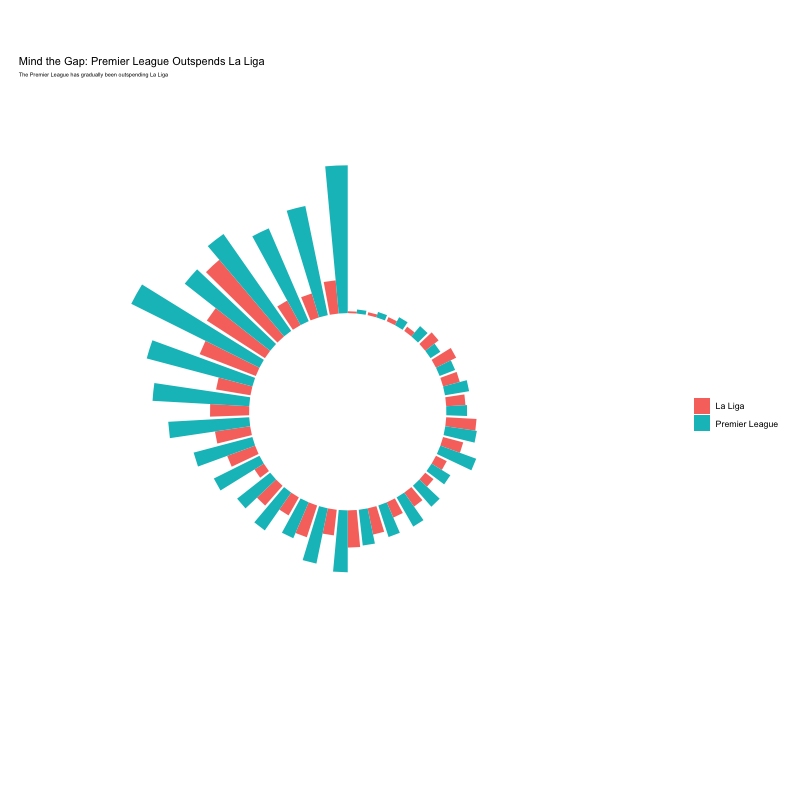

In [118]:
%%R -w 800 -h 800



df_analyse <- df %>% 
  filter(league_name %in% c("Premier League", "Primera Division")) %>%
  mutate(league_name = ifelse(league_name == "Primera Division", "La Liga", league_name))

# aggregate the data by year and league name
df_sum <- df_analyse %>% 
  group_by(year, league_name) %>% 
  summarise(total_spent = sum(fee_cleaned)) %>% 
  ungroup()

# create a new data frame for the labels
label_data <- df_sum %>%
  group_by(year) %>%
  summarise(fee_cleaned = max(total_spent))

# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (as.numeric(factor(label_data$year))-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
 
# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust<-ifelse(angle < -90, 1, 0)
 
# flip angle BY to make them readable
label_data$angle<-ifelse(angle < -90, angle+180, angle)

ggplot(df_sum, aes(x=year, y=total_spent, fill=league_name)) +       
  # This add the bars with a blue color
  geom_bar(stat="identity", position = "dodge") +
  
  # Limits of the plot = very important. The negative value controls the size of the inner circle, the positive one is useful to add size over each bar
  ylim(-1500,2500) +
  
  # Custom the theme: no axis title and no cartesian grid
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm")
  ) +
  
  # This makes the coordinate polar instead of cartesian.
  coord_polar(start = 0) +
  
  # Add the labels, using the label_data dataframe that we have created before
  #geom_text(data=label_data, aes(x=year, y=(fee_cleaned-100)*ifelse(fee_cleaned>0,1,-1), label=fee_cleaned, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=4.5, angle= label_data$angle, inherit.aes = FALSE ) +
  
  # Adjust the size of the title and subtitle
  labs(title = "Mind the Gap: Premier League Outspends La Liga", subtitle = "The Premier League has gradually been outspending La Liga", x = NULL, y = NULL, fill = NULL) +
  theme(plot.title = element_text(size = rel(1)), plot.subtitle = element_text(size = rel(0.5)), plot.margin = unit(c(2, 0.5, 2, 0.5), "cm"))


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


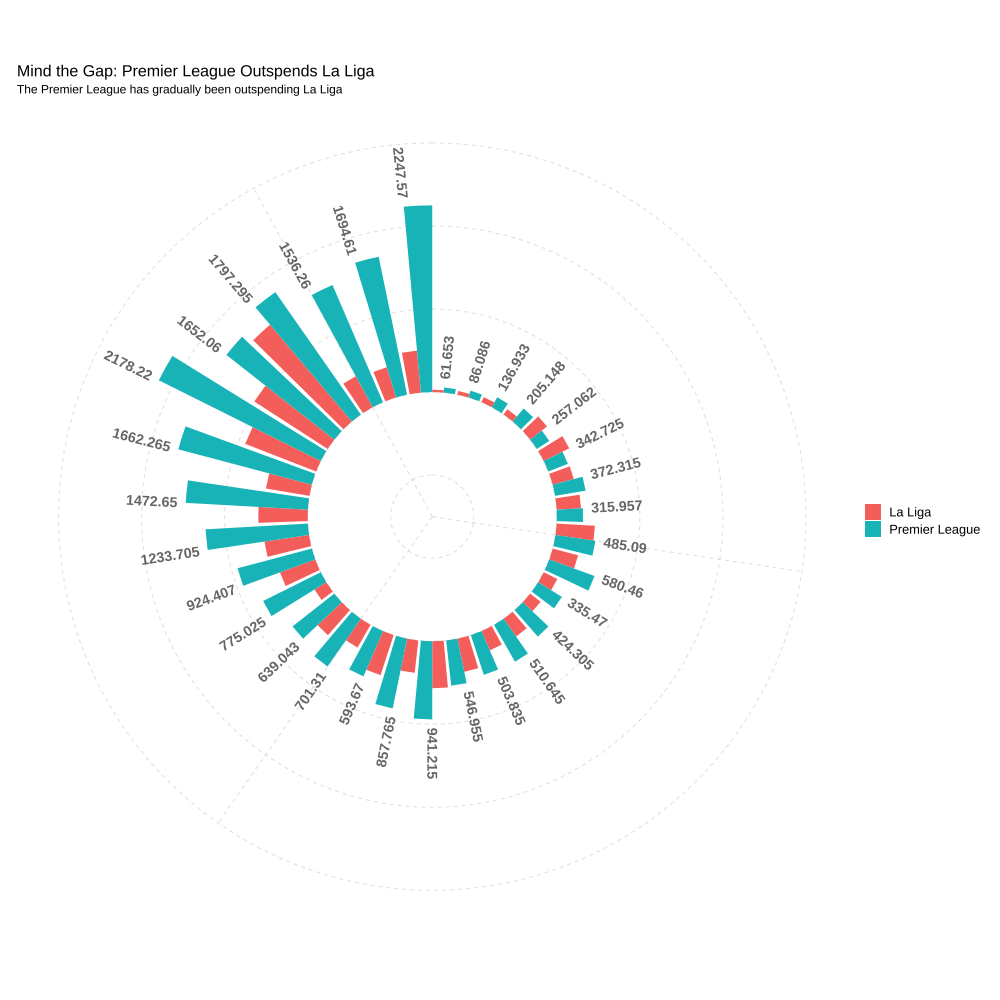

In [170]:
%%R -w 1000 -h 1000


df_analyse <- df %>% 
  filter(league_name %in% c("Premier League", "Primera Division")) %>%
  mutate(league_name = ifelse(league_name == "Primera Division", "La Liga", league_name))

# aggregate the data by year and league name
df_sum <- df_analyse %>% 
  group_by(year, league_name) %>% 
  summarise(total_spent = sum(fee_cleaned)) %>% 
  ungroup()

# create a new data frame for the labels
label_data <- df_sum %>%
  group_by(year) %>%
  summarise(total_spent = max(total_spent))

# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (as.numeric(factor(label_data$year))-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)

# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust <- ifelse(angle < -90, 1, 0)

# flip angle BY to make them readable
label_data$angle <- ifelse(angle < -90, angle+180, angle)

ggplot(df_sum, aes(x=year, y=total_spent, fill=league_name)) +       
  # This add the bars with a blue color
  geom_bar(stat="identity", position = "dodge") +
  
  # Limits of the plot = very important. The negative value controls the size of the inner circle, the positive one is useful to add size over each bar
  ylim(-1500,2500) +
  
  # Custom the theme: no axis title and no cartesian grid
  theme_minimal() +
  theme(
  axis.text = element_blank(),
  axis.title = element_blank(),
  panel.grid = element_blank(),
  plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"),
  text = element_text(family = "Merryweather", size = 16),
  panel.grid.major = element_line(colour = "grey", size = 0.2, linetype = "dashed"),
  panel.grid.minor = element_blank()
) +
  
  # This makes the coordinate polar instead of cartesian.
  coord_polar(start = 0) +
  
  # Add the labels, using the label_data dataframe that we have created before
  geom_text(data=label_data, aes(x=year, y=total_spent + 100, label=total_spent, hjust=hjust), color="black", fontface="bold", alpha=0.6, size=5, angle= label_data$angle, inherit.aes = FALSE ) +
  
  # Adjust the size of the title and subtitle
  labs(title = "Mind the Gap: Premier League Outspends La Liga", subtitle = "The Premier League has gradually been outspending La Liga", x = NULL, y = NULL, fill = NULL) +
  theme(plot.title = element_text(size = 16), plot.subtitle = element_text(size = 12), plot.margin = unit(c(2, 0.5, 2, 0.5), "cm"))


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


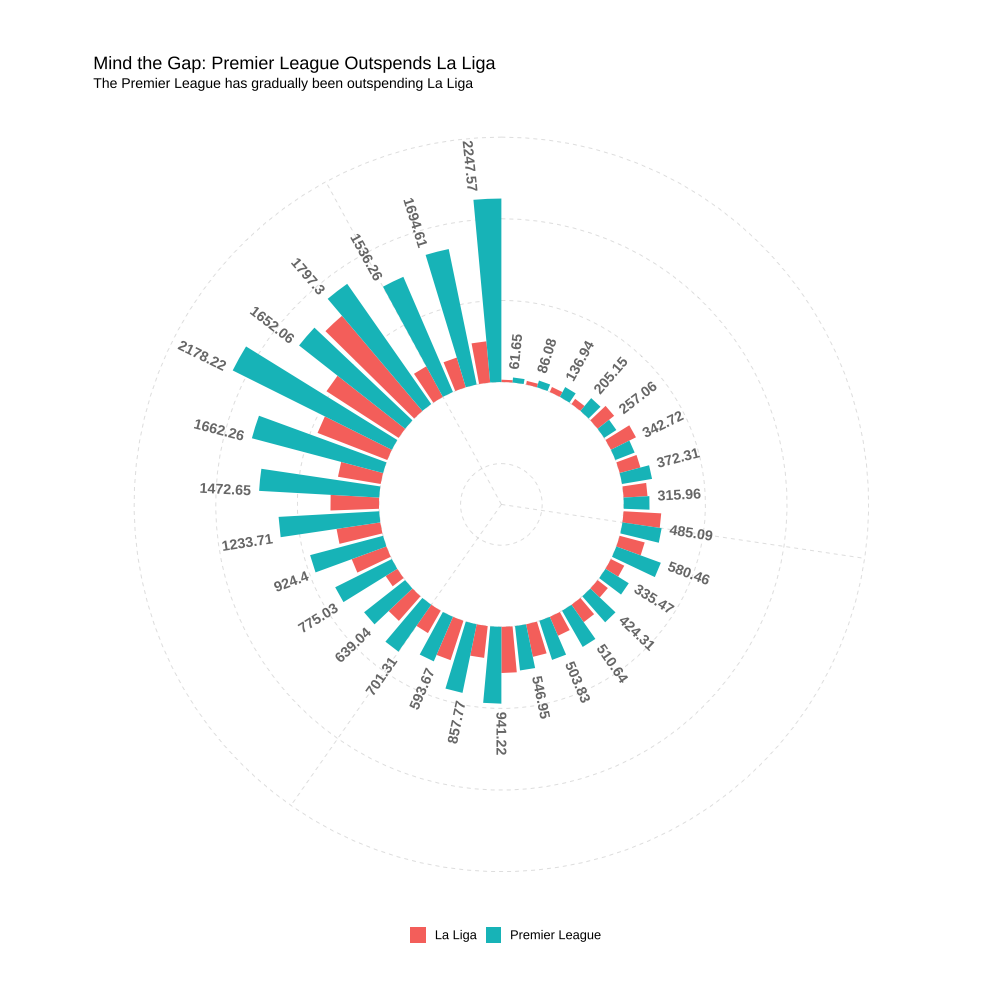

In [173]:

%%R -w 1000 -h 1000

df$fee_cleaned <- round(df$fee_cleaned, 2)

df_analyse <- df %>% 
  filter(league_name %in% c("Premier League", "Primera Division")) %>%
  mutate(league_name = ifelse(league_name == "Primera Division", "La Liga", league_name))

# aggregate the data by year and league name
df_sum <- df_analyse %>% 
  group_by(year, league_name) %>% 
  summarise(total_spent = sum(fee_cleaned)) %>% 
  ungroup()

# create a new data frame for the labels
label_data <- df_sum %>%
  group_by(year) %>%
  summarise(total_spent = max(total_spent))


# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (as.numeric(factor(label_data$year))-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)

# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust <- ifelse(angle < -90, 1, 0)

# flip angle BY to make them readable
label_data$angle <- ifelse(angle < -90, angle+180, angle)

ggplot(df_sum, aes(x=year, y=total_spent, fill=league_name)) +       
  # This add the bars with a blue color
  geom_bar(stat="identity", position = "dodge") +
  
  # Limits of the plot = very important. The negative value controls the size of the inner circle, the positive one is useful to add size over each bar
  ylim(-1500,2500) +
  
  # Custom the theme: no axis title and no cartesian grid
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    text = element_text(family = "Poppins", size = 16),
    panel.grid.major = element_line(colour = "grey", size = 0.2, linetype = "dashed"),
    panel.grid.minor = element_blank(),
    legend.position = "bottom",  # move legend to bottom
    legend.box = "horizontal",   # change legend style to horizontal
    legend.margin = margin(t = -0.1, b = -0.1),  # reduce margin around the legend
    plot.margin = unit(c(0.2, 0.2, 0.2, 0.2), "cm")  # reduce margin around the plot
  ) +
  
  # This makes the coordinate polar instead of cartesian.
  coord_polar(start = 0) +
  
  # Add the labels, using the label_data dataframe that we have created before
  geom_text(data=label_data, aes(x=year, y=total_spent + 100, label=total_spent, hjust=hjust), color="black", fontface="bold", alpha=0.6, size=5, angle= label_data$angle, inherit.aes = FALSE ) +
  
  # Adjust the size of the title and subtitle
  labs(title = "Mind the Gap: Premier League Outspends La Liga", subtitle = "The Premier League has gradually been outspending La Liga", x = NULL, y = NULL, fill = NULL) +
  theme(plot.title = element_text(size = 18), plot.subtitle = element_text(size = 14), plot.margin = unit(c(2, 0.5, 2, 0.5), "cm"))


In [ ]:
library(circlepackeR)

# create data frame with league names and expenditure
df <- data.frame(
  league_name = c("Premier League", "La Liga", "Serie A", "Ligue 1"),
  total_spent = c(930, 25, 30, 110)
)

# create a nested list for circlepackeR
circle_data <- list(
  name = "Leagues",
  children = lapply(1:nrow(df), function(i) {
    list(name = df$league_name[i], size = df$total_spent[i])
  })
)

# create the circle pack plot
circlepackeR(circle_data, color = "category10", legend = TRUE, labels = TRUE)


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


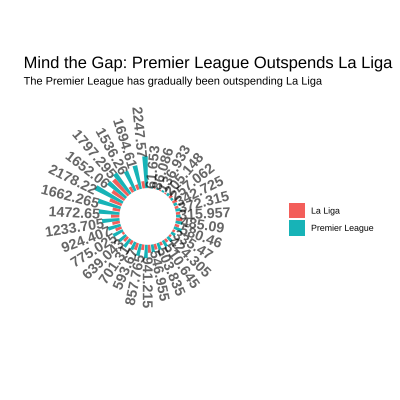

In [133]:
%%R -w 400 -h 400

df_analyse <- df %>% 
  filter(league_name %in% c("Premier League", "Primera Division")) %>%
  mutate(league_name = ifelse(league_name == "Primera Division", "La Liga", league_name))

# aggregate the data by year and league name
df_sum <- df_analyse %>% 
  group_by(year, league_name) %>% 
  summarise(total_spent = sum(fee_cleaned)) %>% 
  ungroup()

# create a new data frame for the labels
label_data <- df_sum %>%
  group_by(year) %>%
  summarise(fee_cleaned = max(total_spent))

# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (as.numeric(factor(label_data$year))-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
 
# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust<-ifelse(angle < -90, 1, 0)
 
# flip angle BY to make them readable
label_data$angle<-ifelse(angle < -90, angle+180, angle)

ggplot(df_sum, aes(x=year, y=total_spent, fill=league_name)) +       
  geom_bar(stat="identity", position = "dodge") +
  ylim(-2000,5000) +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm")
  ) +
  coord_polar(start = 0) +
  geom_text(data=label_data, aes(x=year, y=(fee_cleaned-100)*ifelse(fee_cleaned>0,1,-1), label=fee_cleaned, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=5, angle= label_data$angle, inherit.aes = FALSE ) +
  labs(title = "Mind the Gap: Premier League Outspends La Liga", subtitle = "The Premier League has gradually been outspending La Liga", x = NULL, y = NULL, fill = NULL) +
  theme(plot.title = element_text(size = rel(1.5)), plot.subtitle = element_text(size = rel(1)), plot.margin = unit(c(2, 0.5, 2, 0.5), "cm"))



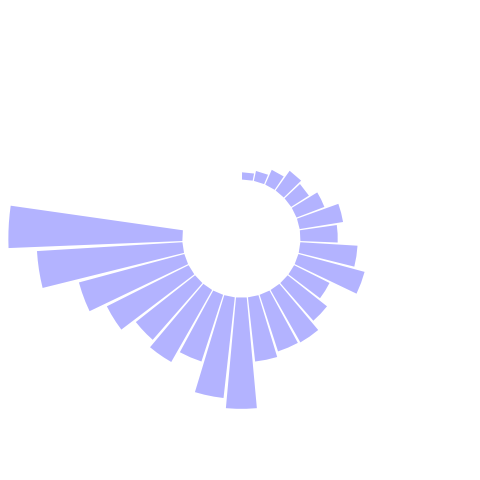

In [65]:
%%R
ggplot(df_, aes(x=Year, y=Amount)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  
  # This add the bars with a blue color
  geom_bar(stat="identity", fill=alpha("blue", 0.3)) +
  
  # Limits of the plot = very important. The negative value controls the size of the inner circle, the positive one is useful to add size over each bar
  ylim(-500,1500) +
  
  # Custom the theme: no axis title and no cartesian grid
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-2,4), "cm")     # This remove unnecessary margin around plot
  ) +
  
  # This makes the coordinate polar instead of cartesian.
  coord_polar(start = 0)

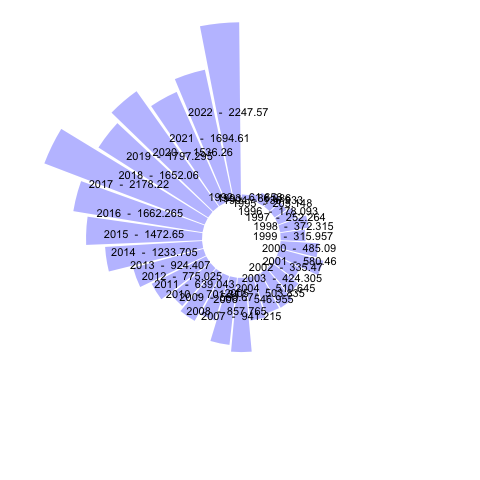

In [66]:
%%R

ggplot(df_premier, aes(x=Year, y=Amount)) +
  geom_bar(stat="identity", fill=alpha("blue", 0.3)) +
  ylim(-500,2500) +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-2,4), "cm")
  ) +
  coord_polar(start = 0) +
  # Add labels for each year and amount
  geom_text(aes(label = paste(Year, " - ", Amount)), position = position_stack(vjust = 0.5))

Error in `geom_bar()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `FUN()`:
! object 'Year' not found
Run `rlang::last_error()` to see where the error occurred.


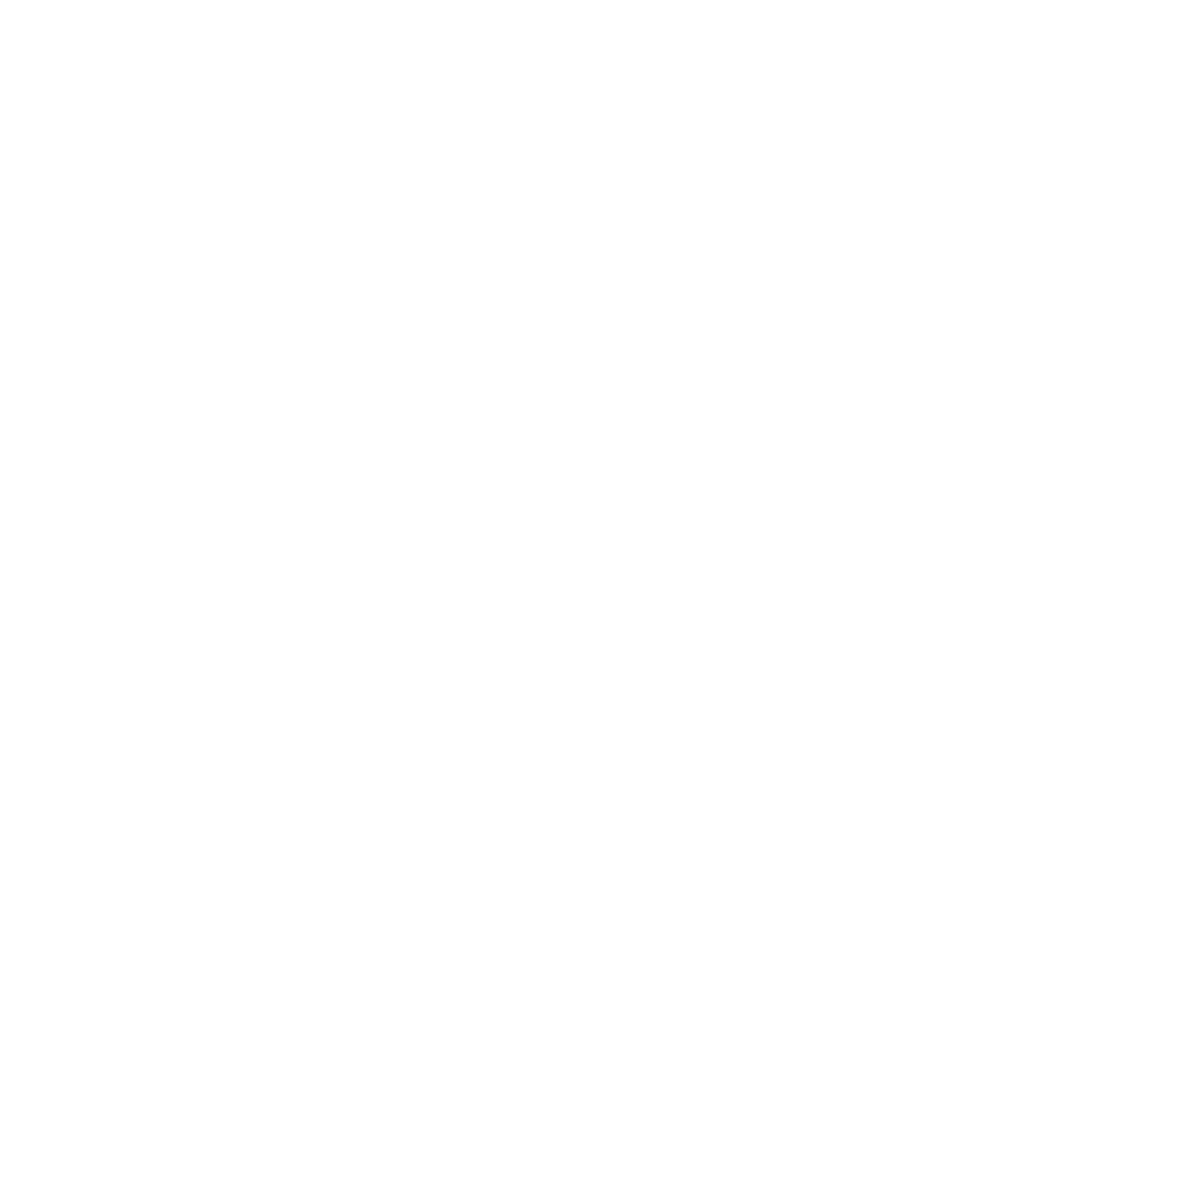

RRuntimeError: Error in geom_bar(stat = "identity", fill = alpha("skyblue", 0.7)) : 
ℹ Error occurred in the 1st layer.
Caused by error in `FUN()`:
! object 'Year' not found


In [88]:
%%R -w 1200 -h 1200

label_data <- df_premier_2000
 
# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (as.numeric(factor(label_data$Year))-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
 
# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust<-ifelse(angle < -90, 1, 0)
 
# flip angle BY to make them readable
label_data$angle<-ifelse(angle < -90, angle+180, angle)

ggplot(df_analyse, aes(x=year, y=Amount)) +       # Note that Year is a factor. If x is numeric, there is some space between the first bar
  
  # This add the bars with a blue color
  geom_bar(stat="identity", fill=alpha("skyblue", 0.7)) +
  
  # Limits of the plot = very important. The negative value controls the size of the inner circle, the positive one is useful to add size over each bar
  ylim(-1000,2500) +
  
  # Custom the theme: no axis title and no cartesian grid
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm")      # Adjust the margin to make in sort labels are not truncated!
  ) +
  
  # This makes the coordinate polar instead of cartesian.
  coord_polar(start = 0) +
  
  # Add the labels, using the label_data dataframe that we have created before
  geom_text(data=label_data, aes(x=year, y=Amount-400, label=paste(year, " - ", Amount), hjust=hjust), color="black", fontface="bold",alpha=0.6, size=5, angle= label_data$angle, inherit.aes = FALSE ) +
 
  
  # Adjust the size of the title and subtitle
  labs(title = "Mind the Gap: Premier League Outspends La Liga", subtitle = "The Premier League has gradually been outspending La Liga") +
  theme(plot.title = element_text(size = rel(2)), plot.subtitle = element_text(size = rel(1.5)), plot.margin = unit(c(2, 0.5, 2, 0.5), "cm"))

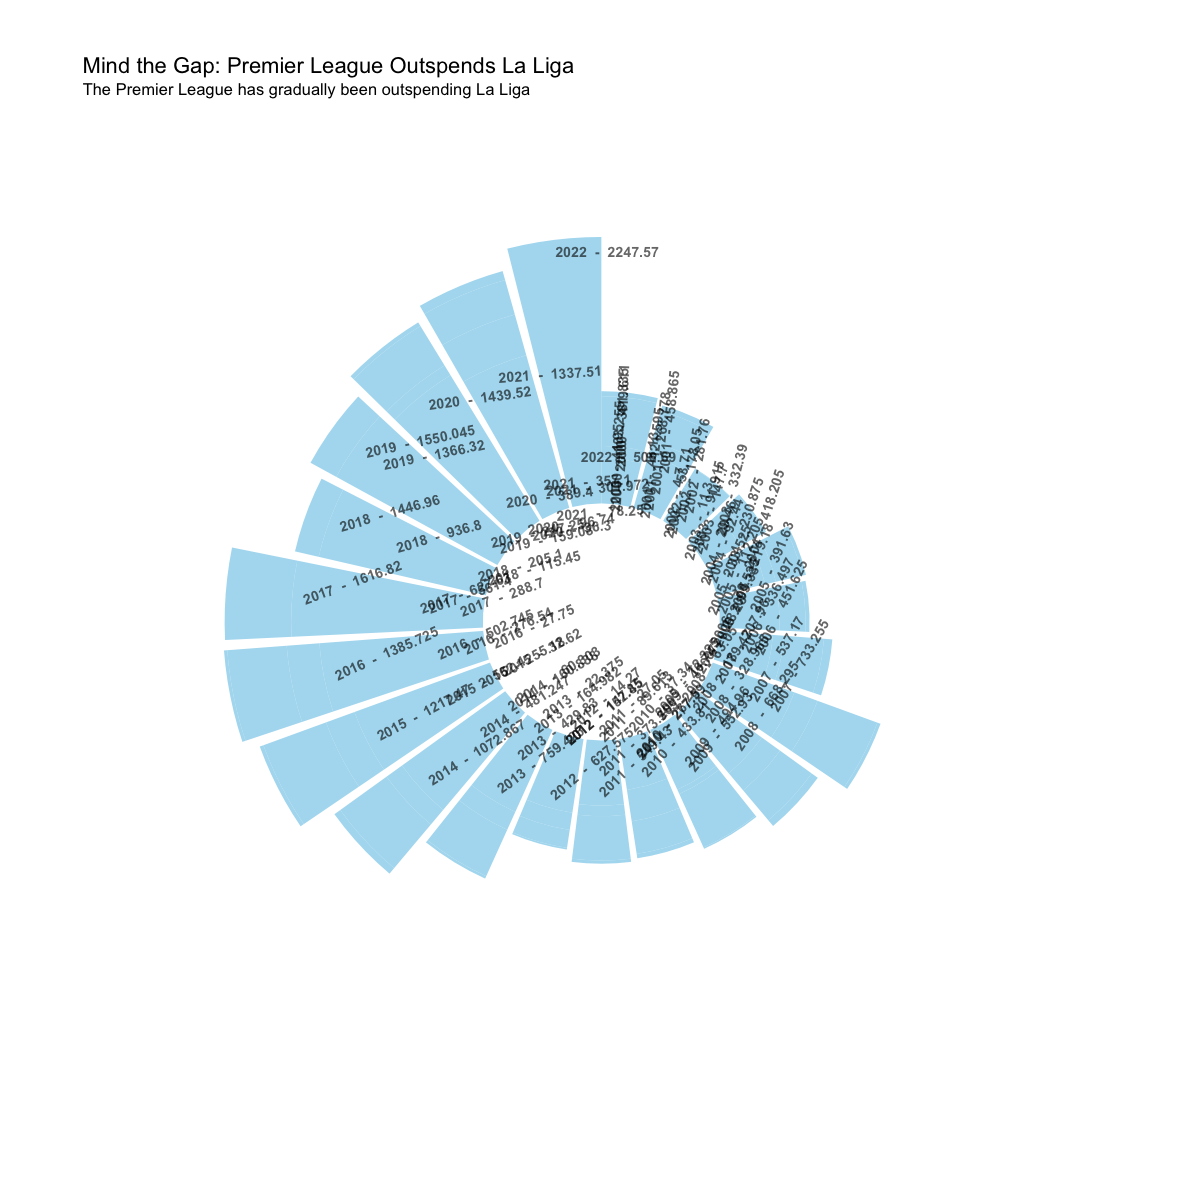

In [107]:
%%R -w 1200 -h 1200

label_data <- df_analyse
 
# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (as.numeric(factor(label_data$year))-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
 
# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust<-ifelse(angle < -90, 1, 0)
 
# flip angle BY to make them readable
label_data$angle<-ifelse(angle < -90, angle+180, angle)

ggplot(df_analyse, aes(x=year, y=fee_cleaned)) +       # Note that Year is a factor. If x is numeric, there is some space between the first bar
  
  # This add the bars with a blue color
  geom_bar(stat="identity", fill=alpha("skyblue", 0.7)) +
  
  # Limits of the plot = very important. The negative value controls the size of the inner circle, the positive one is useful to add size over each bar
  ylim(-1000,2500) +
  
  # Custom the theme: no axis title and no cartesian grid
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm")      # Adjust the margin to make in sort labels are not truncated!
  ) +
  
  # This makes the coordinate polar instead of cartesian.
  coord_polar(start = 0) +
  
  # Add the labels, using the label_data dataframe that we have created before
  geom_text(data=label_data, aes(x=year, y=(fee_cleaned-100)*ifelse(fee_cleaned>0,1,-1), label=paste(year, " - ", fee_cleaned), hjust=hjust), color="black", fontface="bold",alpha=0.6, size=5, angle= label_data$angle, inherit.aes = FALSE ) +
  
  # Adjust the size of the title and subtitle
  labs(title = "Mind the Gap: Premier League Outspends La Liga", subtitle = "The Premier League has gradually been outspending La Liga") +
  theme(plot.title = element_text(size = rel(2)), plot.subtitle = element_text(size = rel(1.5)), plot.margin = unit(c(2, 0.5, 2, 0.5), "cm"))
